# Case study: Reaction times of Schizophrenics

## Objectives and takeaways
1. Take a real-world experiment, write the model.
2. Write a Metropolis sampler, including the proposal distribution.
3. Perform inference using your sampler

## Experiment

We shall work with the experiment published in Belin and Rubin [1] in 1995 that analyzed reaction times to visual stimuli in Schizophrenia.

A total of 17 volunteers performed 30 repetitions of a visual task and their reaction time was measured in milliseconds. There were 6 schizophrenics and 11 healthy volunteers.

Note that in the work [1], the authors do not use a Bayesian approach for estimation but apply an EM procedure. The priors that we define in this work must therefore be our construction.

Below is the original data from the experiment, available [here](http://www.stat.columbia.edu/~gelman/book/data/schiz.asc).

[1] T. Belin and D. Rubin, “The analysis of repeated‐measures data on schizophrenic reaction times using mixture models,” Stat Med, vol. 14, no. 8, pp. 747–768, 1995.

In [1]:
import numpy as np
import pymc3 as pm
import scipy.stats as st
import theano.tensor as tt

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
orig_data = """
312 272 350 286 268 328 298 356 292 308 296 372 396 402 280 330 254 282 350 328 332 308 292 258 340 242 306 328 294 272
354 346 384 342 302 312 322 376 306 402 320 298 308 414 304 422 388 422 426 338 332 426 478 372 392 374 430 388 354 368
256 284 320 274 324 268 370 430 314 312 362 256 342 388 302 366 298 396 274 226 328 274 258 220 236 272 322 284 274 356
260 294 306 292 264 290 272 268 344 362 330 280 354 320 334 276 418 288 338 350 350 324 286 322 280 256 218 256 220 356
204 272 250 260 314 308 246 236 208 268 272 264 308 236 238 350 272 252 252 236 306 238 350 206 260 280 274 318 268 210
590 312 286 310 778 364 318 316 316 298 344 262 274 330 312 310 376 326 346 334 282 292 282 300 290 302 300 306 294 444
308 364 374 278 366 310 358 380 294 334 302 250 542 340 352 322 372 348 460 322 374 370 334 360 318 356 338 346 462 510
244 240 278 262 266 254 240 244 226 266 294 250 284 260 418 280 294 216 308 324 264 232 294 236 226 234 274 258 208 380
232 262 230 222 210 284 232 228 264 246 264 316 260 266 304 268 384 234 308 266 294 254 222 262 278 290 208 232 206 206
318 324 282 364 286 342 306 302 280 306 256 334 332 336 360 344 480 310 336 314 392 284 292 280 320 322 286 406 352 324
240 292 350 254 396 430 260 320 298 312 290 248 276 364 318 434 400 382 318 298 298 248 250 234 280 306 282 234 424 244
276 272 264 258 278 286 314 340 334 364 286 344 312 380 262 324 310 260 280 262 364 316 270 286 326 302 300 302 344 290
374 466 432 376 360 454 478 382 524 410 520 470 514 354 434 380 416 384 462 386 404 362 420 360 390 356 550 372 386 396
594 1014 1586 1344 610 838 772 264 748 1076 446 314 304 1680 1700 334 256 422 302 296 354 322 276 382 502 428 544 286 650 432
402 466 296 348 680 702 500 500 576 624 406 378 586 826 298 882 564 656 716 380 448 506 1714 748 510 810 984 458 390 642
620 714 414 358 460 598 324 442 372 410 998 636 968 490 696 560 562 720 618 456 502 974 1032 470 462 798 716 300 586 574
454 388 344 226 562 766 502 432 608 516 500 796 542 458 448 404 372 524 400 366 374 350 1154 558 440 348 400 460 514 450"""

In [3]:
# the first 11 lines are from controls, the last 6 from schizophrenics
def parse_data():
    rts, idx = [], 0
    for line in orig_data.split('\n'):
        if len(line) == 0: continue
        tokens = line.split(' ')
        rts.append(list(map(int, line.split(' '))))
    return np.array(rts, dtype=np.float)

reaction_times = parse_data()

### Data description
Patients are stored in rows. For example data in line ```reaction_times[0,:]``` shows reaction times in milliseconds for a healthy volunteer (control group) as ```patient_class[0] == 0```.

In [4]:
reaction_times[0,:]

array([312., 272., 350., 286., 268., 328., 298., 356., 292., 308., 296.,
       372., 396., 402., 280., 330., 254., 282., 350., 328., 332., 308.,
       292., 258., 340., 242., 306., 328., 294., 272.])

In [5]:
# reaction times for the first patient with schizophrenia
reaction_times[11,:]

array([276., 272., 264., 258., 278., 286., 314., 340., 334., 364., 286.,
       344., 312., 380., 262., 324., 310., 260., 280., 262., 364., 316.,
       270., 286., 326., 302., 300., 302., 344., 290.])

In [6]:
reaction_times.shape

(17, 30)

In [7]:
Np, Nt = reaction_times.shape

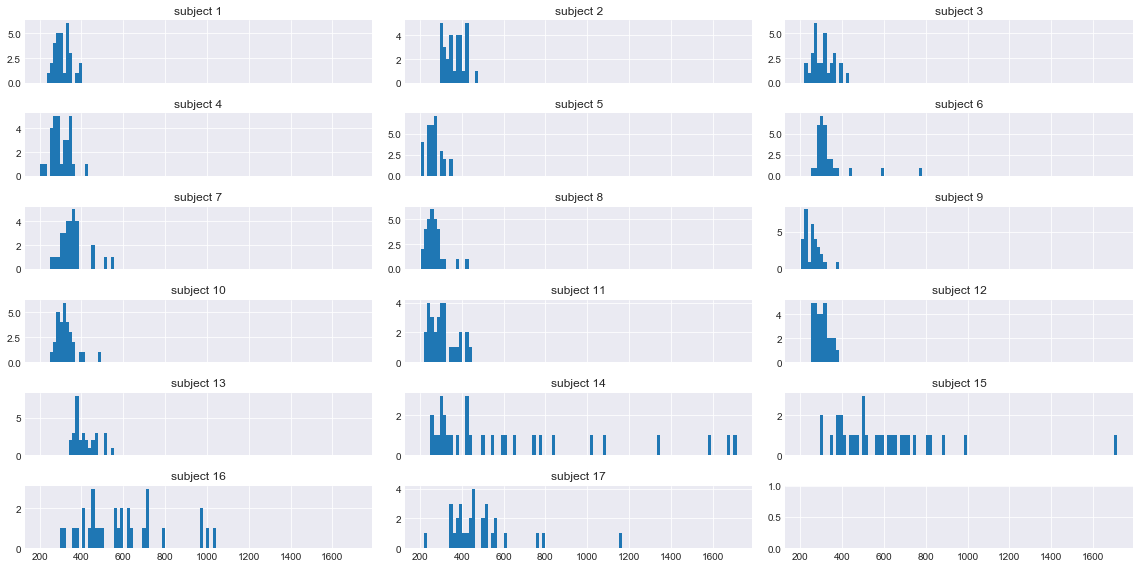

In [8]:
_, axes = plt.subplots(6, 3, figsize=(16, 8), sharex=True)
bins = np.linspace(reaction_times.min(), reaction_times.max(), 100)
axes = axes.flatten()
for isbj in range(Np):
    axes[isbj].hist(reaction_times[isbj, :], bins)
    axes[isbj].set_title('subject %d' %(isbj+1))
plt.tight_layout();

### Model structure
Below we discuss model number 1 from Belin and Rubin [1], who show 3 additional models which had progressively more structure. The other models are not discussed in this notebook.

In the following, we will use the subscript $i \in \{1, 2, ..., 17\}$ to denote participants and $j \in \{1, 2, ..., 30\}$ to denote trials.

It is assumed that each trial participant has their own mean reaction time $\alpha_i$ and that there is a common variance in reaction time that is common to both groups $\sigma^2$.  We know if each participat is in the control group $X_i=0$ or a schizophrenic $X_i=1$ and we observe the reaction time $Y_{i,j}$ for each participant and trial.

In line with psychological theory, the authors assumed that schizophrenics behaved in the same way as the control group participants but in a proportion of the trials $\gamma$, they had difficulty attending to the task (attentional deficit) and thus their reaction time was delayed by $\tau$ milliseconds.

We may formalize the model for the control group as follows:

$$Y_{i,j} \sim {\cal N}(\alpha_i, \sigma^2)$$

and for the schizophrenia group as

$$Y_{i,j} \sim {\cal N}(\alpha_i + Z_{i,j}\tau, \sigma^2),$$

where $Z_{i,j}$ is a latent (unobserved)variable that denotes whether the attentional deficit was present in the trial or not.  We assume

$$Z_{i,j} \sim \text{Bernoulli}(\lambda)$$.

### Priors
Feel free to assume weakly informative priors and experiment. Original recommendations consisted of uniform and inverse gamma distributions but using wide Normal or HalfNormal distributions may work as well. Explore different options.

# Naive model

In [9]:
with pm.Model() as naive:
    sigma = pm.HalfFlat('sigma', testval=reaction_times.std())
    alphas = pm.Flat('alphas', shape=(Np, 1), testval=reaction_times.mean())
    Z = pm.Uniform('Z', 0., 1., shape=(6, Nt))
    lam = pm.Deterministic('lambda', tt.mean(Z, axis=1))
    
    tau = pm.Flat('tau')

    obs_1 = pm.Normal(
        'control', alphas[:11], sigma, observed=reaction_times[:11, :])
    obs_2 = pm.Normal(
        'patient',
        alphas[11:] + Z * tau,
        sigma,
        observed=reaction_times[11:, :])

    MLE = pm.find_MAP()

logp = -3,003.1, ||grad|| = 0.092388: 100%|██████████| 861/861 [00:00<00:00, 1096.91it/s]


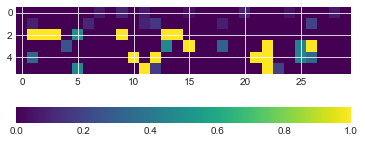

In [10]:
plt.imshow(MLE['Z'], cmap='viridis')
plt.colorbar(orientation="horizontal");

However, the above model is horrible to sample from. Use more explicit model with informative prior

# Explicit model

In [11]:
mean_all, std_all = reaction_times.mean(), reaction_times.std()
sbj_mudiff = np.mean(reaction_times, axis=1) - reaction_times.mean()
sbj_mudiff

array([ -68.5254902 ,  -12.9254902 ,  -73.39215686,  -75.99215686,
       -114.39215686,  -39.79215686,  -21.45882353, -111.1254902 ,
       -121.85882353,  -53.9254902 ,  -70.25882353,  -76.05882353,
         39.4745098 ,  256.2745098 ,  220.2745098 ,  214.74117647,
        108.94117647])

In [12]:
# model with explicit latent Zij
with pm.Model() as explicit:
    # overall mean
    mu = pm.Normal('Intercept', mean_all, std_all)
    sigma = pm.HalfNormal('sigma', 100.)
    alphas_ = pm.Normal('alphas_', sbj_mudiff[:, None], 100., shape=(Np, 1))
    alphas = pm.Deterministic('alphas', mu + alphas_)

    lam = pm.Beta('lambda', 1., 2., shape=(6, 1))
    Z = pm.Bernoulli('Z', lam, shape=(6, Nt))
    tau = pm.HalfNormal('tau', 100.)

    obs_1 = pm.Normal('control',
                      alphas[:11],
                      sigma,
                      observed=reaction_times[:11, :])
    obs_2 = pm.Normal('patient',
                      alphas[11:] + Z * tau,
                      sigma,
                      observed=reaction_times[11:, :])
    trace1 = pm.sample()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [Z]
>NUTS: [tau_log__, lambda_logodds__, alphas_, sigma_log__, Intercept]
100%|██████████| 1000/1000 [00:49<00:00, 20.23it/s]


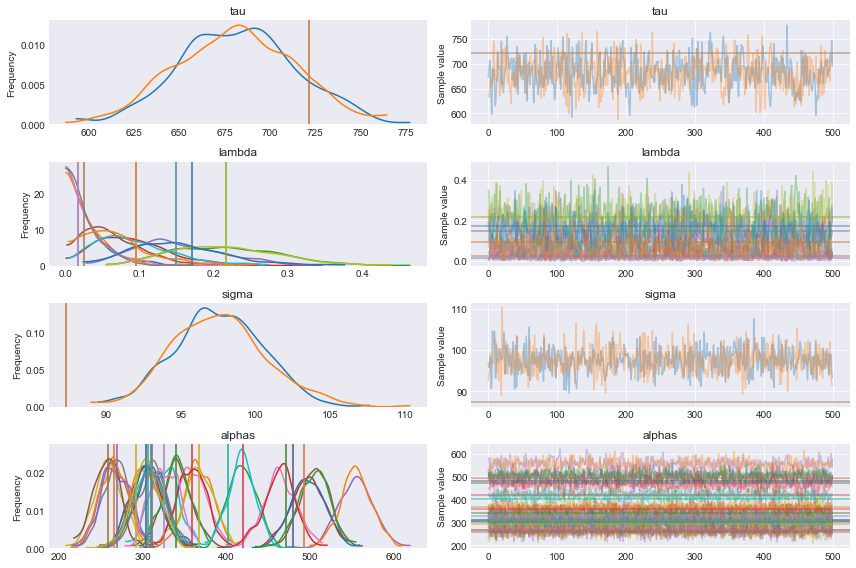

In [13]:
pm.traceplot(trace1, varnames=['tau', 'lambda', 'sigma', 'alphas'], lines=MLE);

In [14]:
pm.summary(trace1, varnames=['tau', 'lambda', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
tau,681.407601,31.996692,1.232953,624.870150,746.549141,573.582425,0.999788
lambda__0_0,0.030259,0.031152,0.000877,0.000006,0.094931,1219.177255,0.999003
lambda__1_0,0.028549,0.027129,0.000756,0.000014,0.079544,1309.983890,1.002402
lambda__2_0,0.215562,0.070736,0.002193,0.083952,0.346357,1295.526996,0.999094
lambda__3_0,0.092671,0.052466,0.001717,0.013336,0.200080,855.852548,0.999000
lambda__4_0,0.152451,0.061703,0.001616,0.036478,0.268602,1143.409990,0.998999
lambda__5_0,0.066296,0.043883,0.001483,0.003044,0.152922,1011.835274,1.002627
sigma,97.531807,3.037894,0.092432,91.691372,103.587166,1156.751810,0.999050


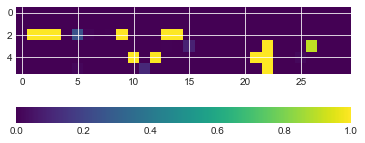

In [15]:
plt.imshow(trace1['Z'].mean(axis=0), cmap='viridis')
plt.colorbar(orientation="horizontal");

In [16]:
alphas1 = np.squeeze(trace1['alphas'])

In [17]:
alphas1.shape

(1000, 17)

In [18]:
np.mean(alphas1,axis=0).shape

(17,)

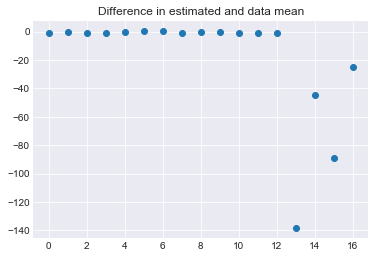

In [19]:
plt.plot(np.mean(alphas1, axis=0) - np.mean(reaction_times, axis=1), 'o')
plt.title('Difference in estimated and data mean');

In [20]:
Z = trace1['Z']
print(Z.shape)

(1000, 6, 30)


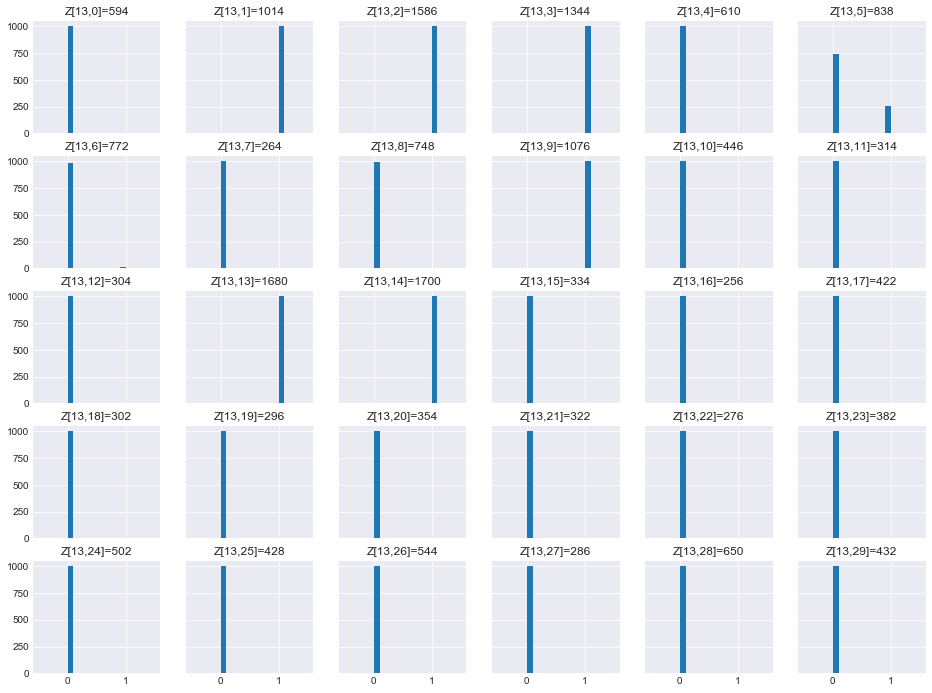

In [21]:
subj_num = 2 # patient id, 0-5
_, axes = plt.subplots(5, 6, figsize=(16, 12), sharex=True, sharey=True)
for i in range(5):
    for j in range(6):
        ax = axes[i, j]
        ax.hist(Z[:, subj_num, i * 6 + j])
        ax.set_title('Z[%d,%d]=%g' % (11 + subj_num, 
                                      i * 6 + j,
                                      reaction_times[11 + subj_num, i * 6 + j]))

# Mariginalized model

In [29]:
# model with explicit latent Zij
with pm.Model() as mariginal:
    # overall mean
    mu = pm.Normal('Intercept', mean_all, std_all)
    sigma = pm.HalfNormal('sigma', 100.)
    alphas_ = pm.Normal('alphas_', sbj_mudiff[:, None], 100., shape=(Np, 1))
    alphas = pm.Deterministic('alphas', mu + alphas_)

    Z_latent = pm.Uniform('Z_latent', 0., 1., shape=(6, Nt))
    lam = pm.Deterministic('lambda', Z_latent.mean(axis=1))
    Z = pm.Deterministic('Z',
                         pm.theanof.tt_rng().binomial(
                             n=1, p=Z_latent, size=(6, Nt)))

    tau = pm.HalfNormal('tau', 100.)

    obs_1 = pm.Normal(
        'control', alphas[:11], sigma, observed=reaction_times[:11, :])
    
    dist1logp = pm.Normal.dist(alphas[11:], sigma).logp(reaction_times[11:, :])
    dist2logp = pm.Normal.dist(alphas[11:] + tau, sigma).logp(
        reaction_times[11:, :])
    mix_logp = pm.math.logsumexp(
        tt.stack(
            [tt.log(1. - Z_latent) + dist1logp,
             tt.log(Z_latent) + dist2logp]), axis=0)
    obs_2 = pm.Potential('patient', mix_logp)
    
    trace2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_log__, Z_latent_interval__, alphas_, sigma_log__, Intercept]
100%|██████████| 2000/2000 [00:21<00:00, 91.85it/s] 
The number of effective samples is smaller than 25% for some parameters.


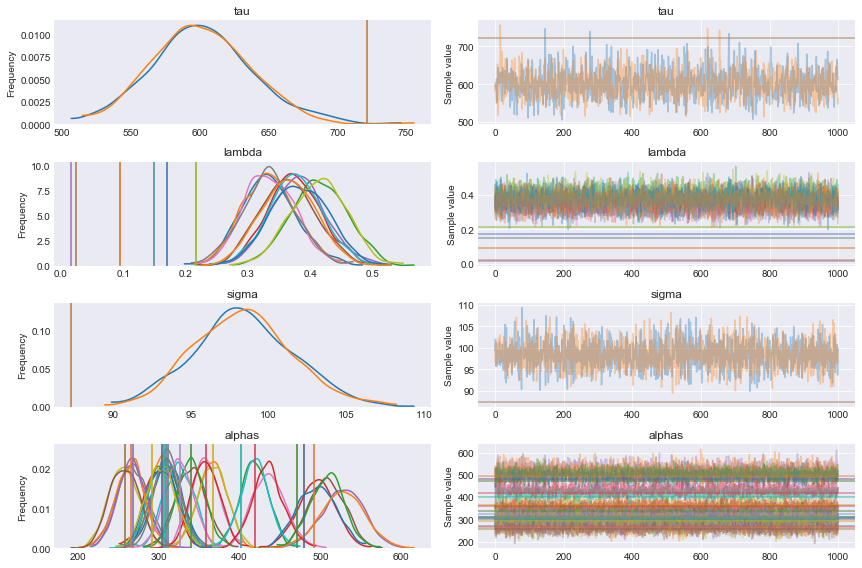

In [30]:
pm.traceplot(trace2, varnames=['tau', 'lambda', 'sigma', 'alphas'], lines=MLE);

In [31]:
pm.summary(trace2, varnames=['tau', 'lambda', 'sigma', 'alphas'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
tau,601.405154,36.380264,0.845633,533.965312,677.178998,1411.612373,0.999731
lambda__0,0.333858,0.042377,0.000813,0.257907,0.421364,2650.483524,0.999552
lambda__1,0.333428,0.042630,0.000817,0.251196,0.417872,3295.228862,0.999503
lambda__2,0.413186,0.044545,0.000781,0.331609,0.501468,3104.894618,0.999573
lambda__3,0.375270,0.043002,0.000787,0.296798,0.463043,2905.378219,0.999612
lambda__4,0.381271,0.045176,0.000699,0.296370,0.471903,3650.827948,0.999603
lambda__5,0.363971,0.044050,0.000747,0.275863,0.445978,3747.426526,0.999526
sigma,98.348384,3.167345,0.054665,92.194272,104.572223,3057.161540,0.999593
alphas__0_0,310.865641,17.081588,0.310599,278.083950,345.079419,3082.940934,0.999714
alphas__1_0,366.301791,17.713072,0.295127,330.903773,399.173932,3905.286813,0.999683


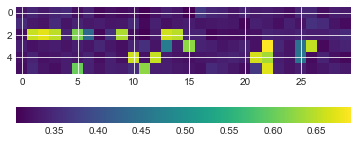

In [32]:
plt.imshow(trace2['Z'].mean(axis=0), cmap='viridis')
plt.colorbar(orientation="horizontal");

In [33]:
alphas1 = np.squeeze(trace2['alphas'])

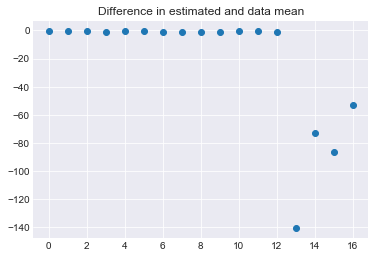

In [34]:
plt.plot(np.mean(alphas1, axis=0) - np.mean(reaction_times, axis=1), 'o')
plt.title('Difference in estimated and data mean');

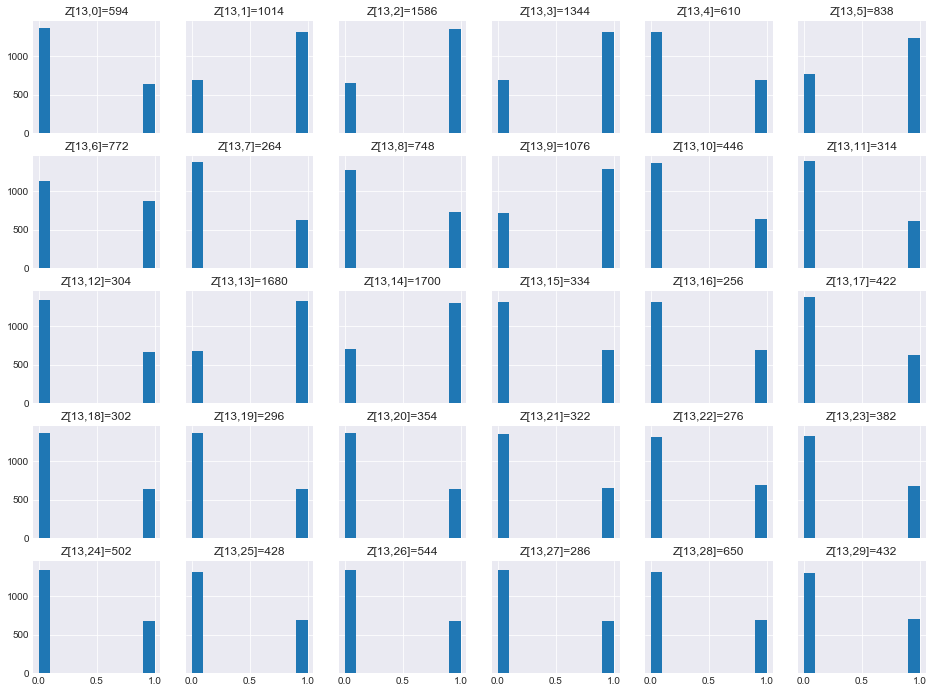

In [35]:
Z = trace2['Z']
subj_num = 2 # patient id, 0-5
_, axes = plt.subplots(5, 6, figsize=(16, 12), sharex=True, sharey=True)
for i in range(5):
    for j in range(6):
        ax = axes[i, j]
        ax.hist(Z[:, subj_num, i * 6 + j])
        ax.set_title('Z[%d,%d]=%g' % (11 + subj_num, 
                                      i * 6 + j,
                                      reaction_times[11 + subj_num, i * 6 + j]))